In [77]:
from financetoolkit import Toolkit
from creds import api_key

companies = Toolkit(['GOOGL'], api_key=api_key, start_date='2006-01-03', end_date='2017-12-04')

historical_data = companies.get_historical_data()

historical_data.tail()

,Adj Close,Close,Cumulative Return,Dividends,High,Low,Open,Return,Volume
Date,,,,,,,,,
2017-11-27,53.600498,53.600498,3.921250,0,53.652000,52.738499,52.928501,0.014661,35430000
2017-11-28,53.164501,53.164501,3.881220,0,54.000000,52.727001,53.699501,-0.008134,36424000
2017-11-29,51.868999,51.868999,3.762275,0,52.938499,51.482498,52.808998,-0.024368,55866000
2017-11-30,51.808498,51.808498,3.756721,0,52.207001,51.503502,51.997002,-0.001166,45092000
2017-12-01,51.253502,51.253502,3.705764,0,51.862000,50.845001,51.520500,-0.010712,37762000


In [78]:
price = historical_data[['Close', 'High', 'Low', 'Open', 'Return', 'Volume']].copy()
price.fillna(0, inplace=True)

In [79]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def split_data(stock, lookback):
    data_raw = stock.to_numpy() 

    scaler = MinMaxScaler(feature_range=(0, 1))

    train_data = data_raw[:int(data_raw.shape[0]*0.7)]
    scaler.fit(train_data)

    data_scaled = scaler.transform(data_raw)

    data = []
    for index in range(len(data_scaled) - lookback): 
        data.append(data_scaled[index: index + lookback])
    
    data = np.array(data)
    
    val_set_size = int(np.round(0.15*data.shape[0]))
    test_set_size = int(np.round(0.15*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0]
    
    x_val = data[train_set_size:train_set_size+val_set_size,:-1,:]
    y_val = data[train_set_size:train_set_size+val_set_size,-1,0]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,0]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test, scaler]

lookback = 20 
x_train, y_train, x_val, y_val, x_test, y_test, scaler = split_data(price, lookback)

In [80]:
def inverse_transform_y(y, x, scaler):
    dummy = np.zeros(shape=(len(y), x.shape[2]))
    dummy[:, 0] = np.ravel(y)
    y_inverse = scaler.inverse_transform(dummy)
    y_inverse = y_inverse[:, 0]
    return y_inverse

In [81]:
import torch

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float().unsqueeze(1)

x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float().unsqueeze(1)

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float().unsqueeze(1)

In [82]:
input_dim = 6
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100

In [83]:
import torch.nn as nn
from torchvision.ops import MLP

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mlp = MLP(hidden_dim, [32, output_dim])

        self.h0 = nn.Parameter(torch.zeros(num_layers, 1, hidden_dim))

    def forward(self, x):
        h0 = self.h0.expand(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.gru(x, h0)
        out = self.mlp(out[:, -1, :])
        return out

In [84]:
import torch.optim as optim

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(num_epochs):
    model.train()

    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.21803663671016693
Epoch 1, Loss: 0.12293628603219986
Epoch 2, Loss: 0.04381838068366051
Epoch 3, Loss: 0.07577544450759888
Epoch 4, Loss: 0.025069110095500946
Epoch 5, Loss: 0.02183968760073185
Epoch 6, Loss: 0.029308056458830833
Epoch 7, Loss: 0.027605876326560974
Epoch 8, Loss: 0.018773170188069344
Epoch 9, Loss: 0.010963366366922855
Epoch 10, Loss: 0.01105465367436409
Epoch 11, Loss: 0.014218217693269253
Epoch 12, Loss: 0.010215665213763714
Epoch 13, Loss: 0.004311070777475834
Epoch 14, Loss: 0.0036878366954624653
Epoch 15, Loss: 0.005521691869944334
Epoch 16, Loss: 0.004482218995690346
Epoch 17, Loss: 0.0013673256617039442
Epoch 18, Loss: 0.00045321034849621356
Epoch 19, Loss: 0.002790772123262286
Epoch 20, Loss: 0.003541177837178111
Epoch 21, Loss: 0.00177237659227103
Epoch 22, Loss: 0.0013358388096094131
Epoch 23, Loss: 0.0024486908223479986
Epoch 24, Loss: 0.002624338958412409
Epoch 25, Loss: 0.0014485132414847612
Epoch 26, Loss: 0.00048123294254764915
Epoch 27,

In [86]:
y_train_pred = model(x_train)
y_train_pred_scaled = inverse_transform_y(y_train_pred.detach().numpy(), x_train.detach().numpy(), scaler)

y_train_scaled = inverse_transform_y(y_train.detach().numpy(), x_train.detach().numpy(), scaler)

In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE = sqrt(mean_squared_error(y_train_scaled, y_train_pred_scaled))
print(f'RMSE: {RMSE:.2f}')

RMSE: 0.31


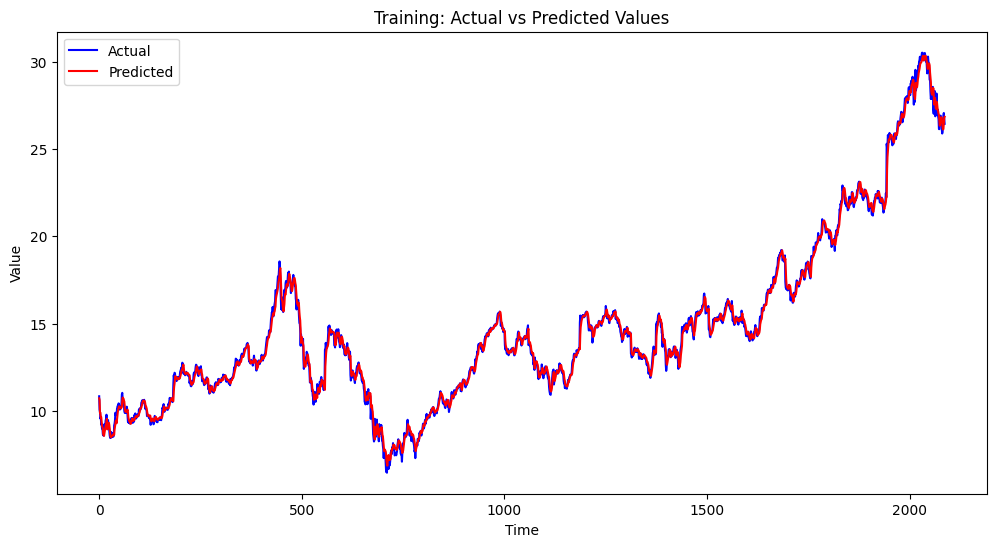

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(y_train_scaled, label='Actual', color='blue')

plt.plot(y_train_pred_scaled, label='Predicted', color='red')

plt.title('Training: Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.show()

In [89]:
model.eval()

with torch.no_grad():
    y_val_pred = model(x_val)
    y_val_pred_scaled = inverse_transform_y(y_val_pred.detach().numpy(), x_val.detach().numpy(), scaler)

y_val_scaled = inverse_transform_y(y_val.detach().numpy(), x_val.detach().numpy(), scaler)

RMSE = sqrt(mean_squared_error(y_val_scaled, y_val_pred_scaled))
print(f'RMSE: {RMSE:.2f}')


RMSE: 0.77


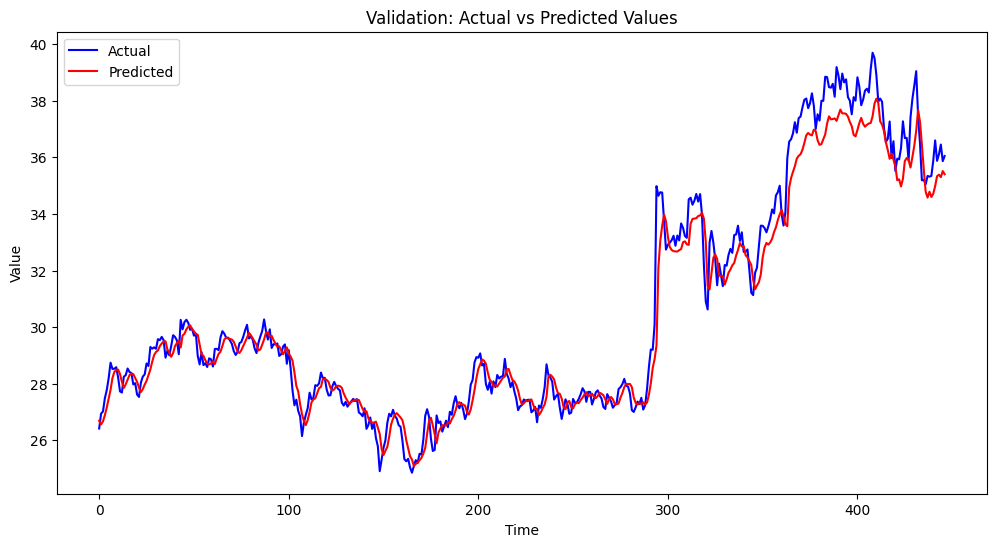

In [90]:
# visualize the validation results

plt.figure(figsize=(12, 6))

plt.plot(y_val_scaled, label='Actual', color='blue')

plt.plot(y_val_pred_scaled, label='Predicted', color='red')

plt.title('Validation: Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.show()

In [91]:
y_test_pred = model(x_test)
y_test_pred_scaled = inverse_transform_y(y_test_pred.detach().numpy(), x_test.detach().numpy(), scaler)

y_test_scaled = inverse_transform_y(y_test.detach().numpy(), x_test.detach().numpy(), scaler)

RMSE = sqrt(mean_squared_error(y_test_scaled, y_test_pred_scaled))
print(f'RMSE: {RMSE:.2f}')

RMSE: 2.71


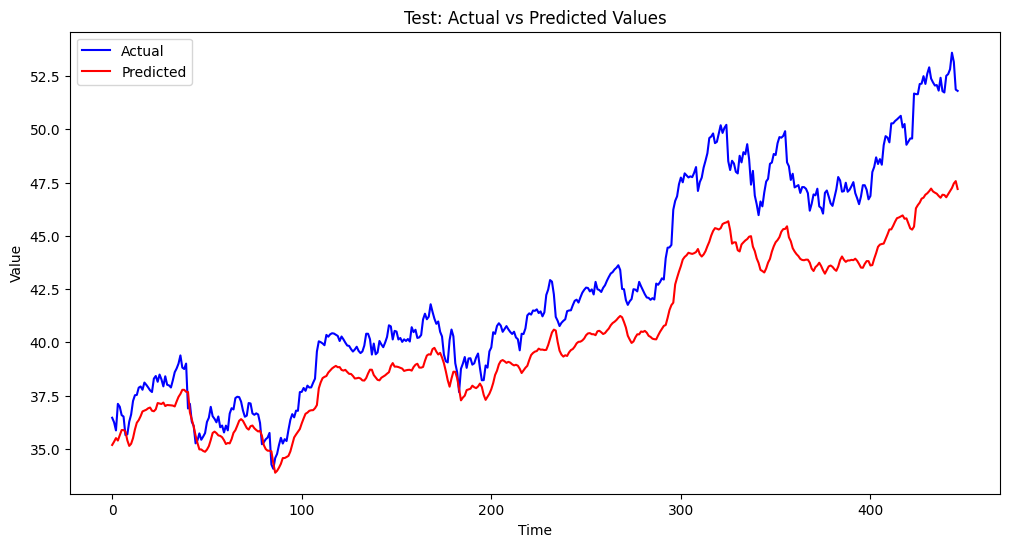

In [92]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_scaled, label='Actual', color='blue')

plt.plot(y_test_pred_scaled, label='Predicted', color='red')

plt.title('Test: Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.show()

How does it generalize to new data that is far in the future? Not well:

In [93]:
companies = Toolkit(['GOOGL'], api_key=api_key, start_date='2018-01-01', end_date='2022-12-31')
new_data = companies.get_historical_data()

new_price = new_data[['Close', 'High', 'Low', 'Open', 'Return', 'Volume']].copy()
new_price.fillna(0, inplace=True)

new_data_raw = new_price.to_numpy() 
new_data_scaled = scaler.transform(new_data_raw)

new_data = []
for index in range(len(new_data_scaled) - lookback): 
    new_data.append(new_data_scaled[index: index + lookback])

new_data = np.array(new_data)
x_new = torch.tensor(new_data[:,:-1,:]).float().to(device)

model.eval()
with torch.no_grad():
    y_new_pred = model(x_new)

y_new_pred_scaled = inverse_transform_y(y_new_pred.detach().numpy(), x_new.detach().numpy(), scaler)

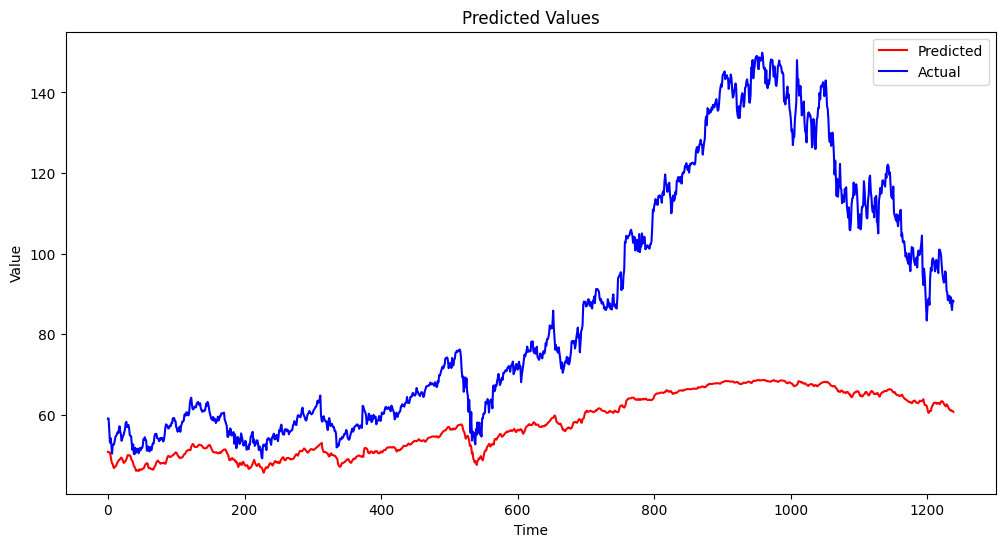

In [94]:
plt.figure(figsize=(12, 6))

plt.plot(y_new_pred_scaled, label='Predicted', color='red')
plt.plot(new_data_raw[lookback:, 0], label='Actual', color='blue')

plt.title('Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.show()

The model is trained on historical data and it learns patterns within that data. However, if the patterns change in the future (which they often do in real-world scenarios), the model’s performance can degrade because it’s still operating under the assumptions learned from the historical data.